# Chapter 2: Small Worlds and Large Worlds

**From Statistical Rethinking by Richard McElreath**

This notebook builds intuition for Bayesian inference by covering:
- Prior, Likelihood, Posterior, and Prediction
- The mathematics behind Bayes theorem
- Grid approximation for computing posteriors
- Complete worked example: The Panda Problem

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)
rng = np.random.default_rng(42)

# Plotting style
plt.style.use('default')
%matplotlib inline

print('✓ Imports loaded')

✓ Imports loaded


---

## 1. Small World vs Large World

### Key Distinction

**Small World (The Model):**
- The formal model we build
- Assumptions are clear and explicit
- Logic is perfect within these assumptions
- Example: "Probability of water is θ, tosses are independent"

**Large World (Reality):**
- The real world where we apply our model
- Messy, complex, full of violations of assumptions
- Model is always an approximation
- Example: Real globe tosses have correlations, measurement error, etc.

### Why This Matters

- Bayesian inference gives us **perfect** answers in the small world
- These answers are only **approximate** in the large world
- Our job: Build models that are useful approximations despite being "wrong"
- Famous quote: "All models are wrong, but some are useful" - George Box

---

## 2. The Bayesian Workflow

### Visual Overview

```
┌─────────────────────────────────────────────────────────┐
│                  BAYESIAN INFERENCE                     │
└─────────────────────────────────────────────────────────┘

    Parameters θ
         ↓
    Prior P(θ)               Before seeing data
         ↓                   What do we believe?
         ├──────────────┐
         ↓              ↓
    Observe Data D   Likelihood P(D|θ)
                        How likely is this data
                        for each possible θ?
         ↓
    MULTIPLY: Prior × Likelihood
         ↓
    NORMALIZE
         ↓
    Posterior P(θ|D)         After seeing data
                             Updated beliefs about θ
         ↓
    Prediction P(D_new|D)    What do we expect
                             for new data?
```

### Key Insight

The posterior is formed by **multiplying** prior and likelihood, then **normalizing**:

$$P(\theta|D) \propto P(D|\theta) \times P(\theta)$$

---

## 3. Prior P(θ)

### What is the Prior?

**Definition:** A probability distribution over parameter values **before** seeing data.

**Intuition:**
- Represents our initial beliefs/knowledge about θ
- Can be informative (strong beliefs) or uninformative (weak beliefs)
- Gets updated by data to form posterior

**Example: Globe Tossing**
- θ = proportion of Earth covered by water
- Before any tosses: P(θ) = Uniform(0, 1)
- All values between 0 and 1 equally likely (uninformative prior)

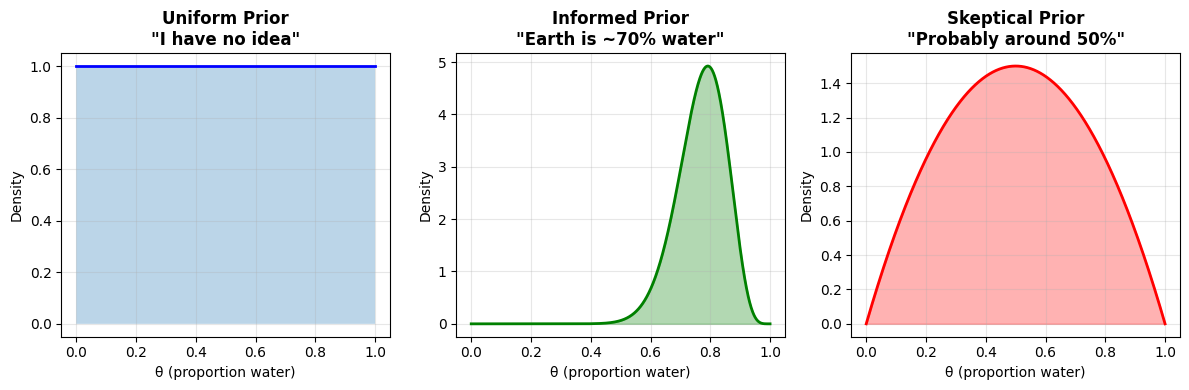

Prior represents our beliefs BEFORE seeing any data
Different priors encode different levels of prior knowledge


In [2]:
# Visualize different priors for θ
theta = np.linspace(0, 1, 1000)

# Three different priors
prior_uniform = np.ones_like(theta)  # Uniform: all values equal
prior_informed = stats.beta.pdf(theta, a=20, b=6)  # Informed: peak around 0.7-0.8
prior_skeptical = stats.beta.pdf(theta, a=2, b=2)  # Skeptical: peak at 0.5

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(theta, prior_uniform, 'b-', linewidth=2)
plt.fill_between(theta, prior_uniform, alpha=0.3)
plt.title('Uniform Prior\n"I have no idea"', fontsize=12, fontweight='bold')
plt.xlabel('θ (proportion water)')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(theta, prior_informed, 'g-', linewidth=2)
plt.fill_between(theta, prior_informed, alpha=0.3, color='g')
plt.title('Informed Prior\n"Earth is ~70% water"', fontsize=12, fontweight='bold')
plt.xlabel('θ (proportion water)')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(theta, prior_skeptical, 'r-', linewidth=2)
plt.fill_between(theta, prior_skeptical, alpha=0.3, color='r')
plt.title('Skeptical Prior\n"Probably around 50%"', fontsize=12, fontweight='bold')
plt.xlabel('θ (proportion water)')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Prior represents our beliefs BEFORE seeing any data")
print("Different priors encode different levels of prior knowledge")

---

## 4. Likelihood P(D|θ)

### What is the Likelihood?

**Definition:** The probability of observing data D given a specific parameter value θ.

**Intuition:**
- For each possible θ, how likely is our observed data?
- Connects parameters to data through a generative model
- Answer the question: "If θ were true, how probable is what we saw?"

### CRITICAL DISTINCTION: Likelihood vs Probability

**As a probability** (function of D, for fixed θ):
- $P(D|\theta)$ sums/integrates to 1 over all possible data
- Example: If θ = 0.7, then P(W|θ) = 0.7 and P(L|θ) = 0.3 sum to 1

**As a likelihood** (function of θ, for fixed D):
- $L(\theta|D)$ does NOT need to sum to 1 over θ
- Same numerical value, different interpretation
- In Bayes theorem, we treat P(D|θ) as a likelihood function

### Example: Globe Tossing

Suppose we toss globe 3 times and observe: W, L, W (water, land, water)

For a given θ:
$$P(W, L, W | \theta) = \theta \times (1-\theta) \times \theta = \theta^2(1-\theta)$$

This is the likelihood function!

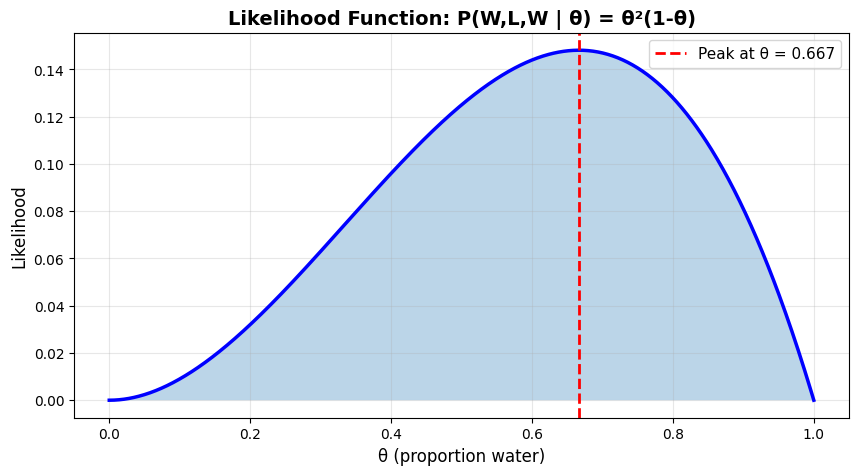

Likelihood Function Properties:
1. Peak (MLE) at θ = 0.667 = 2/3
2. Does NOT integrate to 1: ∫L(θ)dθ = 0.083
3. Higher values = data is more consistent with that θ
4. This is a FUNCTION of θ, not a probability distribution over θ


/tmp/ipykernel_1033788/1902541411.py:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  print(f"2. Does NOT integrate to 1: ∫L(θ)dθ = {np.trapz(likelihood, theta):.3f}")


In [3]:
# Compute likelihood for data D = {W, L, W}
# This means: 2 waters out of 3 tosses

theta = np.linspace(0, 1, 1000)

# Likelihood: θ²(1-θ) for data {W, L, W}
n_water = 2
n_land = 1
likelihood = theta**n_water * (1 - theta)**n_land

plt.figure(figsize=(10, 5))
plt.plot(theta, likelihood, 'b-', linewidth=2.5)
plt.fill_between(theta, likelihood, alpha=0.3)
plt.axvline(theta[np.argmax(likelihood)], color='red', linestyle='--', 
            linewidth=2, label=f'Peak at θ = {theta[np.argmax(likelihood)]:.3f}')
plt.title('Likelihood Function: P(W,L,W | θ) = θ²(1-θ)', fontsize=14, fontweight='bold')
plt.xlabel('θ (proportion water)', fontsize=12)
plt.ylabel('Likelihood', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print("Likelihood Function Properties:")
print(f"1. Peak (MLE) at θ = {theta[np.argmax(likelihood)]:.3f} = 2/3")
print(f"2. Does NOT integrate to 1: ∫L(θ)dθ = {np.trapz(likelihood, theta):.3f}")
print("3. Higher values = data is more consistent with that θ")
print("4. This is a FUNCTION of θ, not a probability distribution over θ")

### Likelihood for Different Datasets

More data = sharper likelihood (more informative)

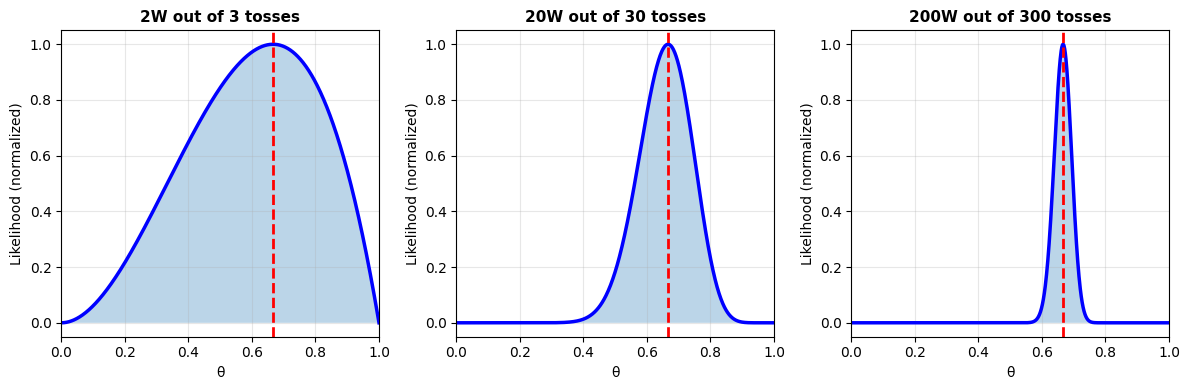

Key Insight: MORE DATA = SHARPER LIKELIHOOD
With more observations, we become more certain about θ


In [4]:
# Compare likelihoods for different amounts of data
theta = np.linspace(0, 1, 1000)

# Different datasets, all with 2/3 proportion water
datasets = [
    (2, 1, "2W out of 3 tosses"),
    (20, 10, "20W out of 30 tosses"),
    (200, 100, "200W out of 300 tosses")
]

plt.figure(figsize=(12, 4))

for idx, (w, l, label) in enumerate(datasets, 1):
    likelihood = theta**w * (1 - theta)**l
    likelihood = likelihood / likelihood.max()  # Normalize for visualization
    
    plt.subplot(1, 3, idx)
    plt.plot(theta, likelihood, 'b-', linewidth=2.5)
    plt.fill_between(theta, likelihood, alpha=0.3)
    plt.axvline(0.667, color='red', linestyle='--', linewidth=2)
    plt.title(label, fontsize=11, fontweight='bold')
    plt.xlabel('θ')
    plt.ylabel('Likelihood (normalized)')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 1)

plt.tight_layout()
plt.show()

print("Key Insight: MORE DATA = SHARPER LIKELIHOOD")
print("With more observations, we become more certain about θ")

---

## 5. Posterior P(θ|D)

### What is the Posterior?

**Definition:** The probability distribution over θ **after** seeing data D.

**Intuition:**
- Updated beliefs about θ
- Combines prior beliefs with information from data
- Answer the question: "Given the data I saw, what do I now believe about θ?"

### Bayes Theorem

$$P(\theta|D) = \frac{P(D|\theta) \times P(\theta)}{P(D)}$$

**Components:**
- $P(\theta|D)$ = **Posterior** (what we want)
- $P(D|\theta)$ = **Likelihood** (connects θ to data)
- $P(\theta)$ = **Prior** (initial beliefs)
- $P(D)$ = **Normalizing constant** (makes posterior sum to 1)

### The Normalizing Constant

$$P(D) = \int P(D|\theta) \times P(\theta) \, d\theta$$

This is also called:
- **Marginal likelihood** (likelihood averaged over prior)
- **Evidence** (in Bayesian model comparison)
- **Average likelihood** (weighted by prior beliefs)

**Practical insight:** We often ignore P(D) during computation:

$$P(\theta|D) \propto P(D|\theta) \times P(\theta)$$

Then normalize at the end so probabilities sum to 1.

/tmp/ipykernel_1033788/4233757500.py:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prior = prior / np.trapz(prior, theta)  # Normalize
/tmp/ipykernel_1033788/4233757500.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  posterior = posterior_unnorm / np.trapz(posterior_unnorm, theta)


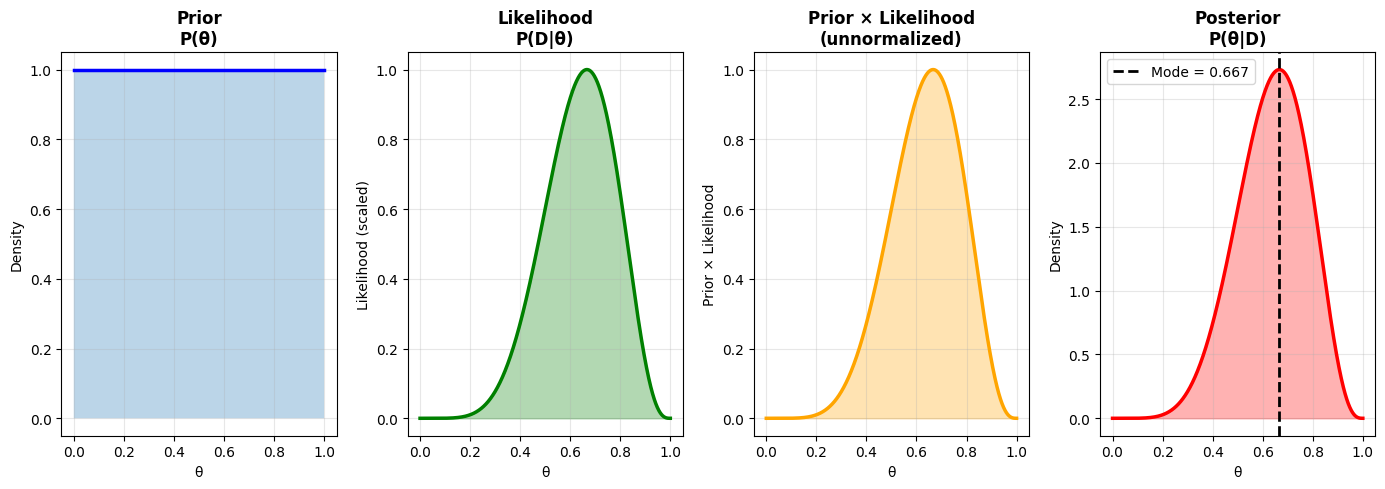

Bayesian Updating:
Data: 6 water out of 9 tosses
Posterior mode: θ = 0.667
Posterior mean: θ = 0.636
95% credible interval: [0.025, 0.975]


/tmp/ipykernel_1033788/4233757500.py:66: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  print(f"Posterior mean: θ = {np.trapz(theta * posterior, theta):.3f}")


In [5]:
# Visualize how Prior × Likelihood → Posterior
theta = np.linspace(0, 1, 1000)

# Data: 6 water out of 9 tosses
n_water = 6
n_land = 3

# Prior: Uniform
prior = np.ones_like(theta)
prior = prior / np.trapz(prior, theta)  # Normalize

# Likelihood
likelihood = theta**n_water * (1 - theta)**n_land
likelihood = likelihood / likelihood.max()  # Scale for visualization

# Posterior (unnormalized)
posterior_unnorm = prior * likelihood

# Posterior (normalized)
posterior = posterior_unnorm / np.trapz(posterior_unnorm, theta)

# Plot
plt.figure(figsize=(14, 5))

plt.subplot(1, 4, 1)
plt.plot(theta, prior, 'b-', linewidth=2.5)
plt.fill_between(theta, prior, alpha=0.3)
plt.title('Prior\nP(θ)', fontsize=12, fontweight='bold')
plt.xlabel('θ')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)

plt.subplot(1, 4, 2)
plt.plot(theta, likelihood, 'g-', linewidth=2.5)
plt.fill_between(theta, likelihood, alpha=0.3, color='g')
plt.title('Likelihood\nP(D|θ)', fontsize=12, fontweight='bold')
plt.xlabel('θ')
plt.ylabel('Likelihood (scaled)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 4, 3)
plt.plot(theta, posterior_unnorm, 'orange', linewidth=2.5)
plt.fill_between(theta, posterior_unnorm, alpha=0.3, color='orange')
plt.title('Prior × Likelihood\n(unnormalized)', fontsize=12, fontweight='bold')
plt.xlabel('θ')
plt.ylabel('Prior × Likelihood')
plt.grid(True, alpha=0.3)

plt.subplot(1, 4, 4)
plt.plot(theta, posterior, 'r-', linewidth=2.5)
plt.fill_between(theta, posterior, alpha=0.3, color='r')
plt.axvline(theta[np.argmax(posterior)], color='black', linestyle='--', 
            linewidth=2, label=f'Mode = {theta[np.argmax(posterior)]:.3f}')
plt.title('Posterior\nP(θ|D)', fontsize=12, fontweight='bold')
plt.xlabel('θ')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Bayesian Updating:")
print(f"Data: {n_water} water out of {n_water + n_land} tosses")
print(f"Posterior mode: θ = {theta[np.argmax(posterior)]:.3f}")
print(f"Posterior mean: θ = {np.trapz(theta * posterior, theta):.3f}")
print(f"95% credible interval: [{np.percentile(theta, 2.5):.3f}, {np.percentile(theta, 97.5):.3f}]")

### How Prior Strength Affects Posterior

Stronger prior = more data needed to change beliefs

/tmp/ipykernel_1033788/1914215853.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prior = prior / np.trapz(prior, theta)
/tmp/ipykernel_1033788/1914215853.py:24: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  posterior = posterior / np.trapz(posterior, theta)


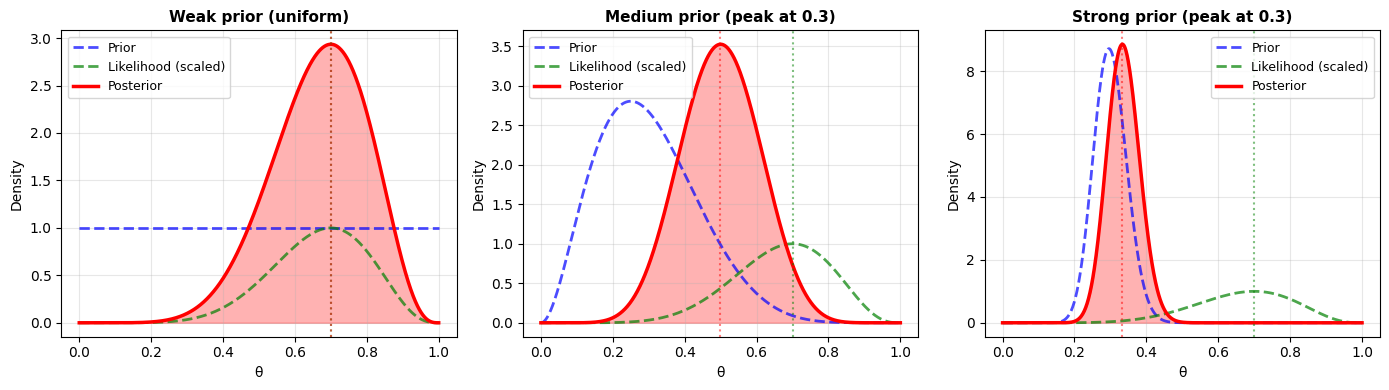

Key Insight:
- Weak prior: Posterior follows likelihood (data dominates)
- Strong prior: Posterior compromises between prior and likelihood
- With enough data, even strong priors get overwhelmed


In [6]:
# Compare posteriors with different prior strengths
theta = np.linspace(0, 1, 1000)

# Data suggests θ ≈ 0.7 (7 water out of 10 tosses)
n_water = 7
n_land = 3
likelihood = theta**n_water * (1 - theta)**n_land

# Three priors of different strengths, all centered at θ=0.3 (conflicting with data!)
priors = [
    (stats.beta.pdf(theta, a=1, b=1), "Weak prior (uniform)"),
    (stats.beta.pdf(theta, a=3, b=7), "Medium prior (peak at 0.3)"),
    (stats.beta.pdf(theta, a=30, b=70), "Strong prior (peak at 0.3)")
]

plt.figure(figsize=(14, 4))

for idx, (prior, label) in enumerate(priors, 1):
    # Normalize prior
    prior = prior / np.trapz(prior, theta)
    
    # Compute posterior
    posterior = prior * likelihood
    posterior = posterior / np.trapz(posterior, theta)
    
    plt.subplot(1, 3, idx)
    plt.plot(theta, prior, 'b--', linewidth=2, label='Prior', alpha=0.7)
    plt.plot(theta, likelihood / likelihood.max(), 'g--', linewidth=2, 
             label='Likelihood (scaled)', alpha=0.7)
    plt.plot(theta, posterior, 'r-', linewidth=2.5, label='Posterior')
    plt.fill_between(theta, posterior, alpha=0.3, color='r')
    plt.axvline(0.7, color='green', linestyle=':', linewidth=1.5, alpha=0.5)
    plt.axvline(theta[np.argmax(posterior)], color='red', linestyle=':', 
                linewidth=1.5, alpha=0.5)
    plt.title(label, fontsize=11, fontweight='bold')
    plt.xlabel('θ')
    plt.ylabel('Density')
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Insight:")
print("- Weak prior: Posterior follows likelihood (data dominates)")
print("- Strong prior: Posterior compromises between prior and likelihood")
print("- With enough data, even strong priors get overwhelmed")

---

## 6. Prediction P(D_new|D)

### CRITICAL DISTINCTION: Posterior vs Prediction

This is a common point of confusion. Let's be crystal clear:

**Posterior P(θ|D):**
- Distribution over **parameters**
- Answers: "What do I believe about θ?"
- After seeing data D

**Prediction P(D_new|D) (Posterior Predictive):**
- Distribution over **new data**
- Answers: "What new observations do I expect?"
- Uses the posterior to make predictions

### The Posterior Predictive Distribution

$$P(D_{new}|D) = \int P(D_{new}|\theta) \times P(\theta|D) \, d\theta$$

**Intuition:**
1. For each possible θ value (weighted by posterior)
2. Generate predictions using that θ
3. Average across all θ values

**Why we need this:**
- Accounts for uncertainty in θ
- Predictions are more uncertain than if we knew θ exactly
- More honest about our uncertainty

/tmp/ipykernel_1033788/339095888.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  posterior = posterior / np.trapz(posterior, theta_grid)
/tmp/ipykernel_1033788/339095888.py:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  posterior_pred[i] = np.trapz(likelihood_new * posterior, theta_grid)


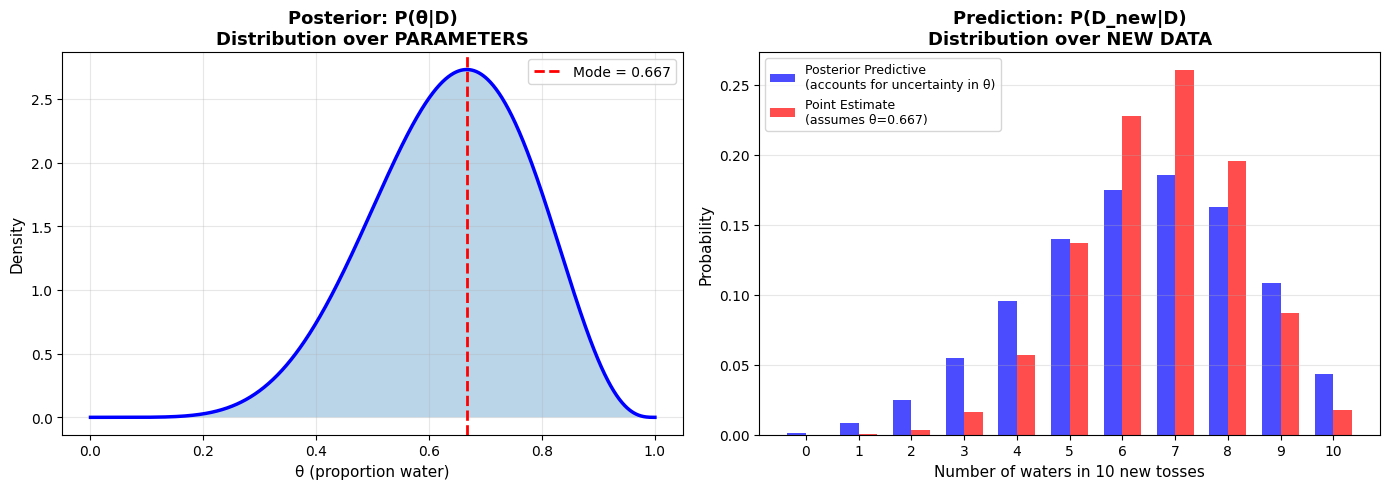

Key Differences:

1. POSTERIOR (left):
   - Tells us about θ (the parameter)
   - Peak at θ = 0.667
   - 95% CI: [0.025, 0.975]

2. POSTERIOR PREDICTIVE (right, blue):
   - Tells us about future data
   - Most likely: 7 waters out of 10
   - WIDER than point estimate (more honest uncertainty)
   - Accounts for our uncertainty about θ


In [7]:
# Demonstrate posterior vs posterior predictive

# Setup: We observed 6 water out of 9 tosses
n_water_obs = 6
n_land_obs = 3

# Grid approximation for posterior
theta_grid = np.linspace(0, 1, 1000)
prior = np.ones_like(theta_grid)
likelihood = theta_grid**n_water_obs * (1 - theta_grid)**n_land_obs
posterior = prior * likelihood
posterior = posterior / np.trapz(posterior, theta_grid)

# Now predict: If we toss 10 more times, how many waters?
n_new_tosses = 10
n_waters_possible = np.arange(0, n_new_tosses + 1)

# Posterior predictive: For each possible outcome, integrate over θ
posterior_pred = np.zeros(len(n_waters_possible))

for i, n_w in enumerate(n_waters_possible):
    # For each θ, compute P(n_w waters | θ, 10 tosses)
    likelihood_new = stats.binom.pmf(n_w, n_new_tosses, theta_grid)
    # Weight by posterior and integrate
    posterior_pred[i] = np.trapz(likelihood_new * posterior, theta_grid)

# Compare to prediction if θ were known exactly (point estimate)
theta_point = theta_grid[np.argmax(posterior)]  # Posterior mode
pred_point = stats.binom.pmf(n_waters_possible, n_new_tosses, theta_point)

# Plot comparison
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(theta_grid, posterior, 'b-', linewidth=2.5)
plt.fill_between(theta_grid, posterior, alpha=0.3)
plt.axvline(theta_point, color='red', linestyle='--', linewidth=2,
            label=f'Mode = {theta_point:.3f}')
plt.title('Posterior: P(θ|D)\nDistribution over PARAMETERS', 
          fontsize=13, fontweight='bold')
plt.xlabel('θ (proportion water)', fontsize=11)
plt.ylabel('Density', fontsize=11)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
x = np.arange(len(n_waters_possible))
width = 0.35
plt.bar(x - width/2, posterior_pred, width, label='Posterior Predictive\n(accounts for uncertainty in θ)',
        alpha=0.7, color='blue')
plt.bar(x + width/2, pred_point, width, label=f'Point Estimate\n(assumes θ={theta_point:.3f})',
        alpha=0.7, color='red')
plt.xticks(x, n_waters_possible)
plt.title('Prediction: P(D_new|D)\nDistribution over NEW DATA', 
          fontsize=13, fontweight='bold')
plt.xlabel('Number of waters in 10 new tosses', fontsize=11)
plt.ylabel('Probability', fontsize=11)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Key Differences:")
print("\n1. POSTERIOR (left):")
print("   - Tells us about θ (the parameter)")
print(f"   - Peak at θ = {theta_point:.3f}")
print(f"   - 95% CI: [{np.percentile(theta_grid, 2.5):.3f}, {np.percentile(theta_grid, 97.5):.3f}]")
print("\n2. POSTERIOR PREDICTIVE (right, blue):")
print("   - Tells us about future data")
print(f"   - Most likely: {n_waters_possible[np.argmax(posterior_pred)]} waters out of 10")
print("   - WIDER than point estimate (more honest uncertainty)")
print("   - Accounts for our uncertainty about θ")

---

## 7. Sequential Updating

### The Updating Interpretation

One of the most powerful features of Bayesian inference:

**Today's Posterior = Tomorrow's Prior**

```
Start:       P(θ)
              ↓
Observe D₁:  P(θ|D₁)  ← This becomes the new prior
              ↓
Observe D₂:  P(θ|D₁,D₂)  ← Update again
              ↓
Observe D₃:  P(θ|D₁,D₂,D₃)  ← Keep updating
```

### Key Properties

1. **Order doesn't matter**: P(θ|D₁,D₂) = P(θ|D₂,D₁)
2. **Can process data one at a time**: Useful for streaming data
3. **Always learning**: Each observation refines our beliefs
4. **Converges**: With enough data, prior influence vanishes

/tmp/ipykernel_1033788/2946461176.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prior = prior / np.trapz(prior, theta_grid)
/tmp/ipykernel_1033788/2946461176.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  current_posterior = current_posterior / np.trapz(current_posterior, theta_grid)
/tmp/ipykernel_1033788/2946461176.py:78: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Mean: {np.trapz(theta_grid * posteriors[-1], theta_grid):.3f}


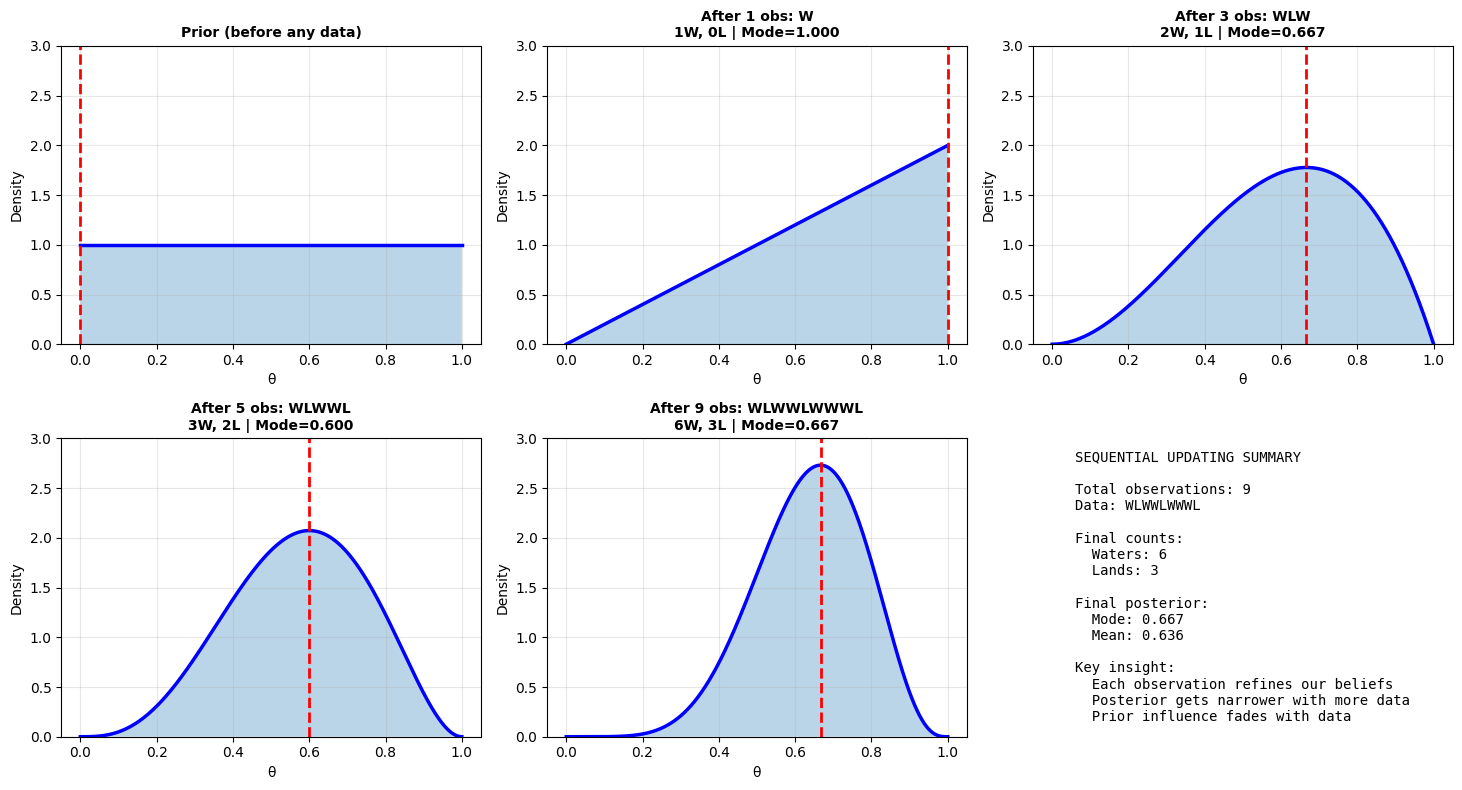

In [8]:
# Demonstrate sequential updating with globe tosses

# Sequence of observations: W, L, W, W, L, W, W, W, L
observations = ['W', 'L', 'W', 'W', 'L', 'W', 'W', 'W', 'L']

theta_grid = np.linspace(0, 1, 1000)
prior = np.ones_like(theta_grid)  # Start with uniform
prior = prior / np.trapz(prior, theta_grid)

# Store posteriors after each observation
posteriors = [prior.copy()]

# Update sequentially
current_posterior = prior.copy()
n_water = 0
n_land = 0

for obs in observations:
    # Update counts
    if obs == 'W':
        n_water += 1
    else:
        n_land += 1
    
    # Today's posterior becomes tomorrow's prior
    prior = current_posterior
    
    # Compute likelihood for this single observation
    likelihood = theta_grid if obs == 'W' else (1 - theta_grid)
    
    # Update
    current_posterior = prior * likelihood
    current_posterior = current_posterior / np.trapz(current_posterior, theta_grid)
    
    posteriors.append(current_posterior.copy())

# Plot evolution
plt.figure(figsize=(15, 8))

snapshots = [0, 1, 3, 5, 9]  # Show these time points
for idx, snap in enumerate(snapshots, 1):
    plt.subplot(2, 3, idx)
    plt.plot(theta_grid, posteriors[snap], 'b-', linewidth=2.5)
    plt.fill_between(theta_grid, posteriors[snap], alpha=0.3)
    
    mode = theta_grid[np.argmax(posteriors[snap])]
    plt.axvline(mode, color='red', linestyle='--', linewidth=2)
    
    if snap == 0:
        title = 'Prior (before any data)'
    else:
        obs_so_far = ''.join(observations[:snap])
        n_w = obs_so_far.count('W')
        n_l = obs_so_far.count('L')
        title = f'After {snap} obs: {obs_so_far}\n{n_w}W, {n_l}L | Mode={mode:.3f}'
    
    plt.title(title, fontsize=10, fontweight='bold')
    plt.xlabel('θ')
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, posteriors[-1].max() * 1.1)

# Add final summary
plt.subplot(2, 3, 6)
plt.axis('off')
summary = f"""
SEQUENTIAL UPDATING SUMMARY

Total observations: {len(observations)}
Data: {''.join(observations)}

Final counts:
  Waters: {n_water}
  Lands: {n_land}
  
Final posterior:
  Mode: {theta_grid[np.argmax(posteriors[-1])]:.3f}
  Mean: {np.trapz(theta_grid * posteriors[-1], theta_grid):.3f}
  
Key insight:
  Each observation refines our beliefs
  Posterior gets narrower with more data
  Prior influence fades with data
"""
plt.text(0.1, 0.5, summary, fontsize=10, family='monospace',
         verticalalignment='center')

plt.tight_layout()
plt.show()

---

## 8. Grid Approximation

### What is Grid Approximation?

**Problem:** For most models, we can't compute the posterior analytically.

**Solution:** Grid approximation treats the continuous posterior as a discrete distribution:

1. Define a grid of parameter values: θ = [0, 0.01, 0.02, ..., 0.99, 1.0]
2. Compute prior at each grid point
3. Compute likelihood at each grid point
4. Multiply: posterior ∝ prior × likelihood
5. Normalize: divide by sum so probabilities sum to 1

### Why It Works

- Approximates continuous distribution with discrete one
- Like approximating an integral with a sum (Riemann sum)
- Finer grid → better approximation (but slower)

### Limitations

- Only works for small number of parameters (curse of dimensionality)
- 1000 grid points for 1 parameter = fine
- 1000 grid points for 10 parameters = 1000¹⁰ combinations = intractable!
- For complex models, need MCMC (later in book)

/tmp/ipykernel_1033788/2572486355.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  posterior = posterior / np.trapz(posterior, theta_grid)


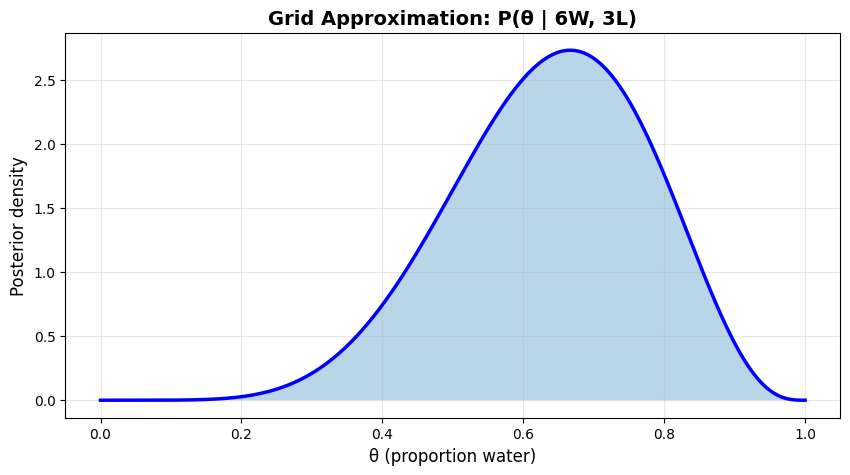

Grid Approximation Algorithm:
1. Define grid ✓
2. Compute prior ✓
3. Compute likelihood ✓
4. Multiply ✓
5. Normalize ✓


In [9]:
def grid_approximation(n_water, n_tosses, grid_size=1000, prior_fn=None):
    """
    Compute posterior using grid approximation.
    
    Parameters:
    -----------
    n_water : int
        Number of water observations
    n_tosses : int
        Total number of tosses
    grid_size : int
        Number of grid points
    prior_fn : function
        Function that takes theta and returns prior density
        Default: uniform prior
    
    Returns:
    --------
    theta_grid : array
        Grid of parameter values
    posterior : array
        Posterior probability at each grid point
    """
    # Step 1: Define grid
    theta_grid = np.linspace(0, 1, grid_size)
    
    # Step 2: Compute prior
    if prior_fn is None:
        prior = np.ones_like(theta_grid)  # Uniform
    else:
        prior = prior_fn(theta_grid)
    
    # Step 3: Compute likelihood
    n_land = n_tosses - n_water
    likelihood = theta_grid**n_water * (1 - theta_grid)**n_land
    
    # Step 4: Multiply (unstandardized posterior)
    posterior = prior * likelihood
    
    # Step 5: Normalize
    posterior = posterior / np.trapz(posterior, theta_grid)
    
    return theta_grid, posterior

# Test the function
theta_grid, posterior = grid_approximation(n_water=6, n_tosses=9)

plt.figure(figsize=(10, 5))
plt.plot(theta_grid, posterior, 'b-', linewidth=2.5)
plt.fill_between(theta_grid, posterior, alpha=0.3)
plt.title('Grid Approximation: P(θ | 6W, 3L)', fontsize=14, fontweight='bold')
plt.xlabel('θ (proportion water)', fontsize=12)
plt.ylabel('Posterior density', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print("Grid Approximation Algorithm:")
print("1. Define grid ✓")
print("2. Compute prior ✓")
print("3. Compute likelihood ✓")
print("4. Multiply ✓")
print("5. Normalize ✓")

### Effect of Grid Size

/tmp/ipykernel_1033788/2572486355.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  posterior = posterior / np.trapz(posterior, theta_grid)


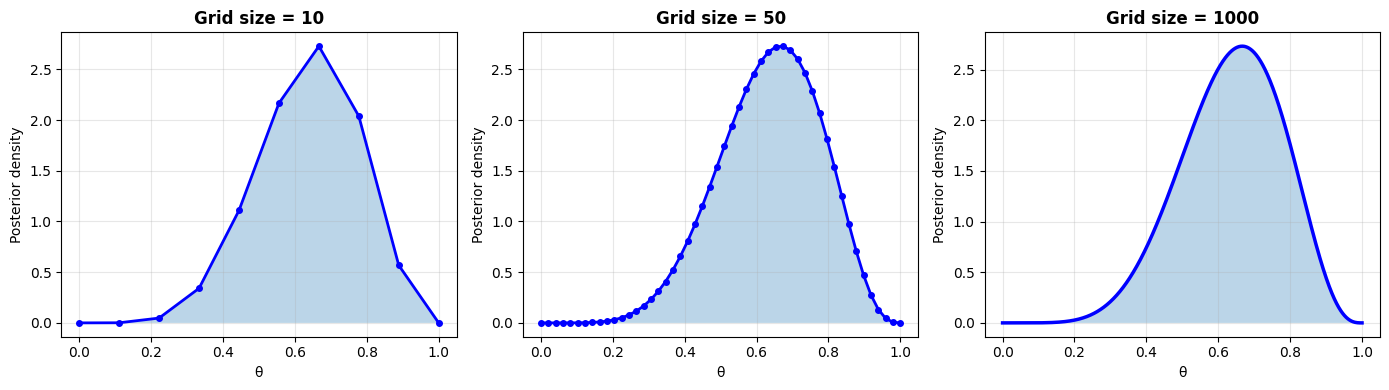

Observations:
- Small grid (10): Coarse, but captures shape
- Medium grid (50): Smoother, good approximation
- Large grid (1000): Very smooth, excellent approximation

Trade-off: Accuracy vs Computation time


In [10]:
# Compare different grid sizes
grid_sizes = [10, 50, 1000]

plt.figure(figsize=(14, 4))

for idx, grid_size in enumerate(grid_sizes, 1):
    theta_grid, posterior = grid_approximation(6, 9, grid_size=grid_size)
    
    plt.subplot(1, 3, idx)
    if grid_size <= 50:
        plt.plot(theta_grid, posterior, 'bo-', linewidth=2, markersize=4)
    else:
        plt.plot(theta_grid, posterior, 'b-', linewidth=2.5)
    plt.fill_between(theta_grid, posterior, alpha=0.3)
    plt.title(f'Grid size = {grid_size}', fontsize=12, fontweight='bold')
    plt.xlabel('θ')
    plt.ylabel('Posterior density')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations:")
print("- Small grid (10): Coarse, but captures shape")
print("- Medium grid (50): Smoother, good approximation")
print("- Large grid (1000): Very smooth, excellent approximation")
print("\nTrade-off: Accuracy vs Computation time")

---

## 9. THE PANDA PROBLEM

Now let's apply everything we've learned to solve the panda problem from the book!

### Problem Setup

**Background:**
- There are two species of pandas: Species A and Species B
- They look identical, so we can't tell them apart by appearance
- But they differ in their probability of having twins:
  - Species A: 10% chance of twins, 90% chance of single birth
  - Species B: 20% chance of twins, 80% chance of single birth

**Question:**
A panda at the zoo gives birth to twins. What's the probability it's Species A vs Species B?

### Setting Up the Model

**Parameters:**
- Let's call the species S ∈ {A, B}

**Prior P(S):**
- Without any information, assume equal probability:
- P(Species A) = 0.5
- P(Species B) = 0.5

**Likelihood P(Twins|S):**
- P(Twins | Species A) = 0.1
- P(Twins | Species B) = 0.2

**Data D:**
- We observed: Twins!

**Goal:**
- Compute posterior: P(Species | Twins)

### Solution Using Bayes Theorem

We want to compute:
$$P(\text{Species A} | \text{Twins})$$

Using Bayes theorem:
$$P(\text{A} | \text{Twins}) = \frac{P(\text{Twins} | \text{A}) \times P(\text{A})}{P(\text{Twins})}$$

The normalizing constant P(Twins) is:
$$P(\text{Twins}) = P(\text{Twins}|\text{A}) \times P(\text{A}) + P(\text{Twins}|\text{B}) \times P(\text{B})$$

This is the **law of total probability** - we compute the probability of twins by considering all possible species.

In [11]:
# Panda Problem: Bayesian Solution

# Setup
print("="*70)
print("THE PANDA PROBLEM")
print("="*70)

# Prior probabilities
p_species_a = 0.5
p_species_b = 0.5

print("\n1. PRIOR (before seeing birth):")
print(f"   P(Species A) = {p_species_a}")
print(f"   P(Species B) = {p_species_b}")
print("   Equal probability - we have no preference")

# Likelihoods
p_twins_given_a = 0.1
p_twins_given_b = 0.2

print("\n2. LIKELIHOOD (how likely are twins for each species):")
print(f"   P(Twins | Species A) = {p_twins_given_a}")
print(f"   P(Twins | Species B) = {p_twins_given_b}")
print("   Species B is 2× more likely to have twins!")

# Normalizing constant (average likelihood)
p_twins = (p_twins_given_a * p_species_a + 
           p_twins_given_b * p_species_b)

print("\n3. NORMALIZING CONSTANT:")
print(f"   P(Twins) = P(Twins|A)×P(A) + P(Twins|B)×P(B)")
print(f"   P(Twins) = {p_twins_given_a}×{p_species_a} + {p_twins_given_b}×{p_species_b}")
print(f"   P(Twins) = {p_twins}")
print("   This is the total probability of observing twins")

# Posterior probabilities
p_a_given_twins = (p_twins_given_a * p_species_a) / p_twins
p_b_given_twins = (p_twins_given_b * p_species_b) / p_twins

print("\n4. POSTERIOR (after seeing twins):")
print(f"   P(Species A | Twins) = {p_a_given_twins:.4f} = {p_a_given_twins:.1%}")
print(f"   P(Species B | Twins) = {p_b_given_twins:.4f} = {p_b_given_twins:.1%}")
print(f"\n   Sum check: {p_a_given_twins + p_b_given_twins:.4f} ✓")

print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)
print(f"After observing twins, we believe:")
print(f"  - {p_b_given_twins:.1%} chance it's Species B")
print(f"  - {p_a_given_twins:.1%} chance it's Species A")
print(f"\nSpecies B is {p_b_given_twins/p_a_given_twins:.1f}× more likely!")
print(f"\nWhy? Species B has higher twin rate, so seeing twins")
print(f"is stronger evidence for Species B than Species A.")

THE PANDA PROBLEM

1. PRIOR (before seeing birth):
   P(Species A) = 0.5
   P(Species B) = 0.5
   Equal probability - we have no preference

2. LIKELIHOOD (how likely are twins for each species):
   P(Twins | Species A) = 0.1
   P(Twins | Species B) = 0.2
   Species B is 2× more likely to have twins!

3. NORMALIZING CONSTANT:
   P(Twins) = P(Twins|A)×P(A) + P(Twins|B)×P(B)
   P(Twins) = 0.1×0.5 + 0.2×0.5
   P(Twins) = 0.15000000000000002
   This is the total probability of observing twins

4. POSTERIOR (after seeing twins):
   P(Species A | Twins) = 0.3333 = 33.3%
   P(Species B | Twins) = 0.6667 = 66.7%

   Sum check: 1.0000 ✓

INTERPRETATION
After observing twins, we believe:
  - 66.7% chance it's Species B
  - 33.3% chance it's Species A

Species B is 2.0× more likely!

Why? Species B has higher twin rate, so seeing twins
is stronger evidence for Species B than Species A.


### Visualizing the Panda Problem

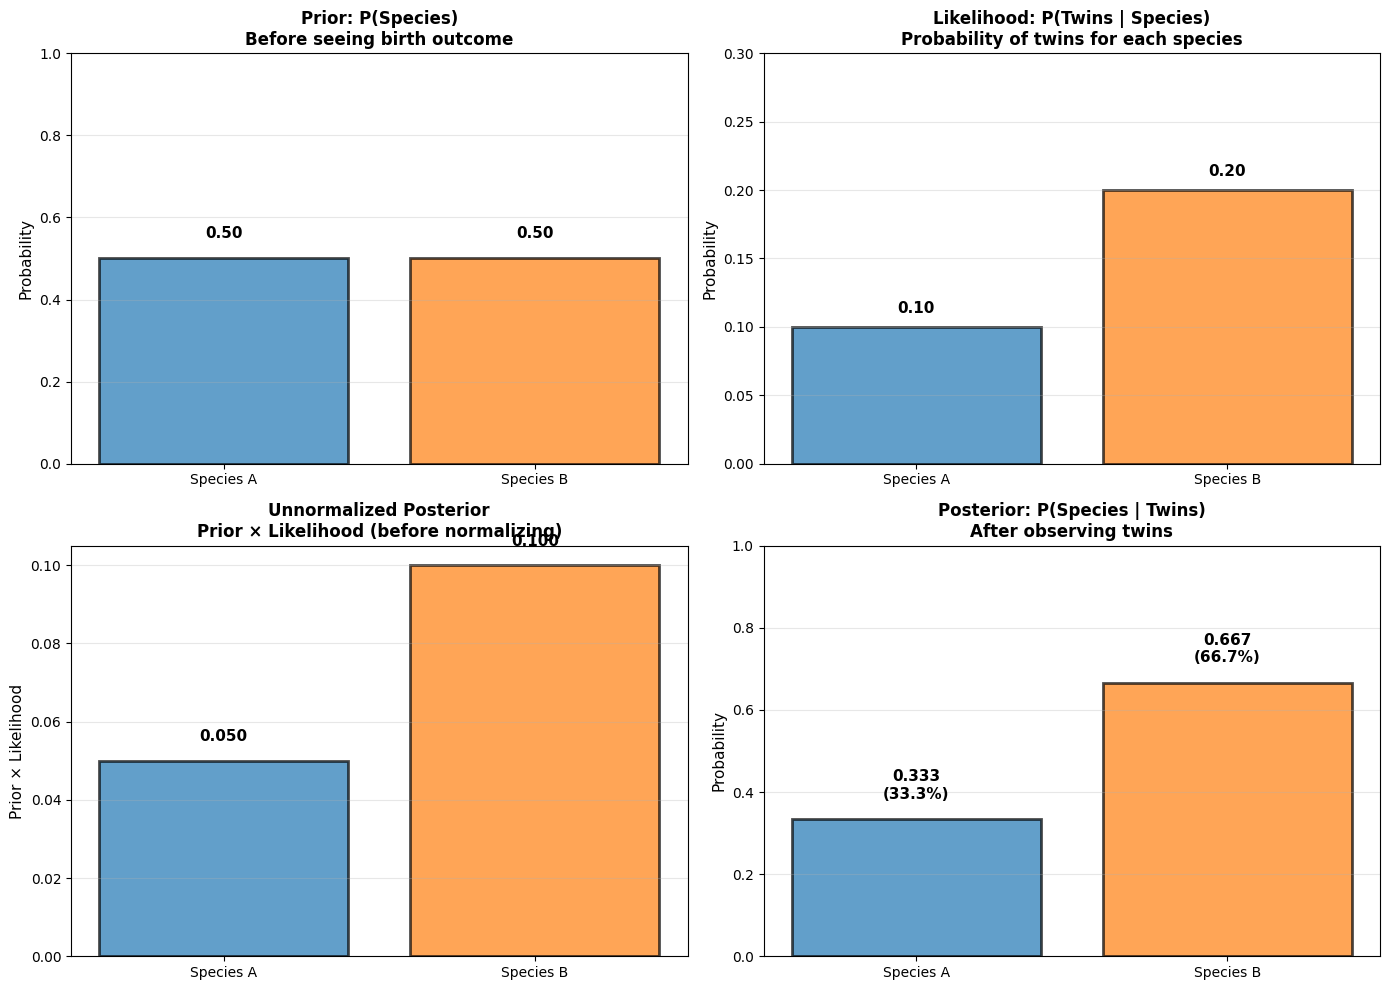


The Journey from Prior to Posterior:

1. Start with equal prior (50/50)
2. Species B has 2× higher twin rate (likelihood)
3. Multiply: Species B gets 2× more weight
4. Normalize: Species B ends up at 67%, Species A at 33%


In [12]:
# Visual representation of the panda problem

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Prior distribution
ax = axes[0, 0]
species = ['Species A', 'Species B']
prior_probs = [p_species_a, p_species_b]
colors = ['#1f77b4', '#ff7f0e']
ax.bar(species, prior_probs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Probability', fontsize=11)
ax.set_title('Prior: P(Species)\nBefore seeing birth outcome', 
             fontsize=12, fontweight='bold')
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(prior_probs):
    ax.text(i, v + 0.05, f'{v:.2f}', ha='center', fontsize=11, fontweight='bold')

# 2. Likelihood
ax = axes[0, 1]
likelihood_probs = [p_twins_given_a, p_twins_given_b]
ax.bar(species, likelihood_probs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Probability', fontsize=11)
ax.set_title('Likelihood: P(Twins | Species)\nProbability of twins for each species', 
             fontsize=12, fontweight='bold')
ax.set_ylim(0, 0.3)
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(likelihood_probs):
    ax.text(i, v + 0.01, f'{v:.2f}', ha='center', fontsize=11, fontweight='bold')

# 3. Unnormalized posterior (Prior × Likelihood)
ax = axes[1, 0]
unnorm_post = [p_species_a * p_twins_given_a, p_species_b * p_twins_given_b]
ax.bar(species, unnorm_post, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Prior × Likelihood', fontsize=11)
ax.set_title('Unnormalized Posterior\nPrior × Likelihood (before normalizing)', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(unnorm_post):
    ax.text(i, v + 0.005, f'{v:.3f}', ha='center', fontsize=11, fontweight='bold')

# 4. Posterior
ax = axes[1, 1]
posterior_probs = [p_a_given_twins, p_b_given_twins]
bars = ax.bar(species, posterior_probs, color=colors, alpha=0.7, 
              edgecolor='black', linewidth=2)
ax.set_ylabel('Probability', fontsize=11)
ax.set_title('Posterior: P(Species | Twins)\nAfter observing twins', 
             fontsize=12, fontweight='bold')
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(posterior_probs):
    ax.text(i, v + 0.05, f'{v:.3f}\n({v:.1%})', ha='center', 
            fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nThe Journey from Prior to Posterior:")
print("\n1. Start with equal prior (50/50)")
print("2. Species B has 2× higher twin rate (likelihood)")
print("3. Multiply: Species B gets 2× more weight")
print("4. Normalize: Species B ends up at 67%, Species A at 33%")

### Decision Tree Visualization

Another way to think about this problem:

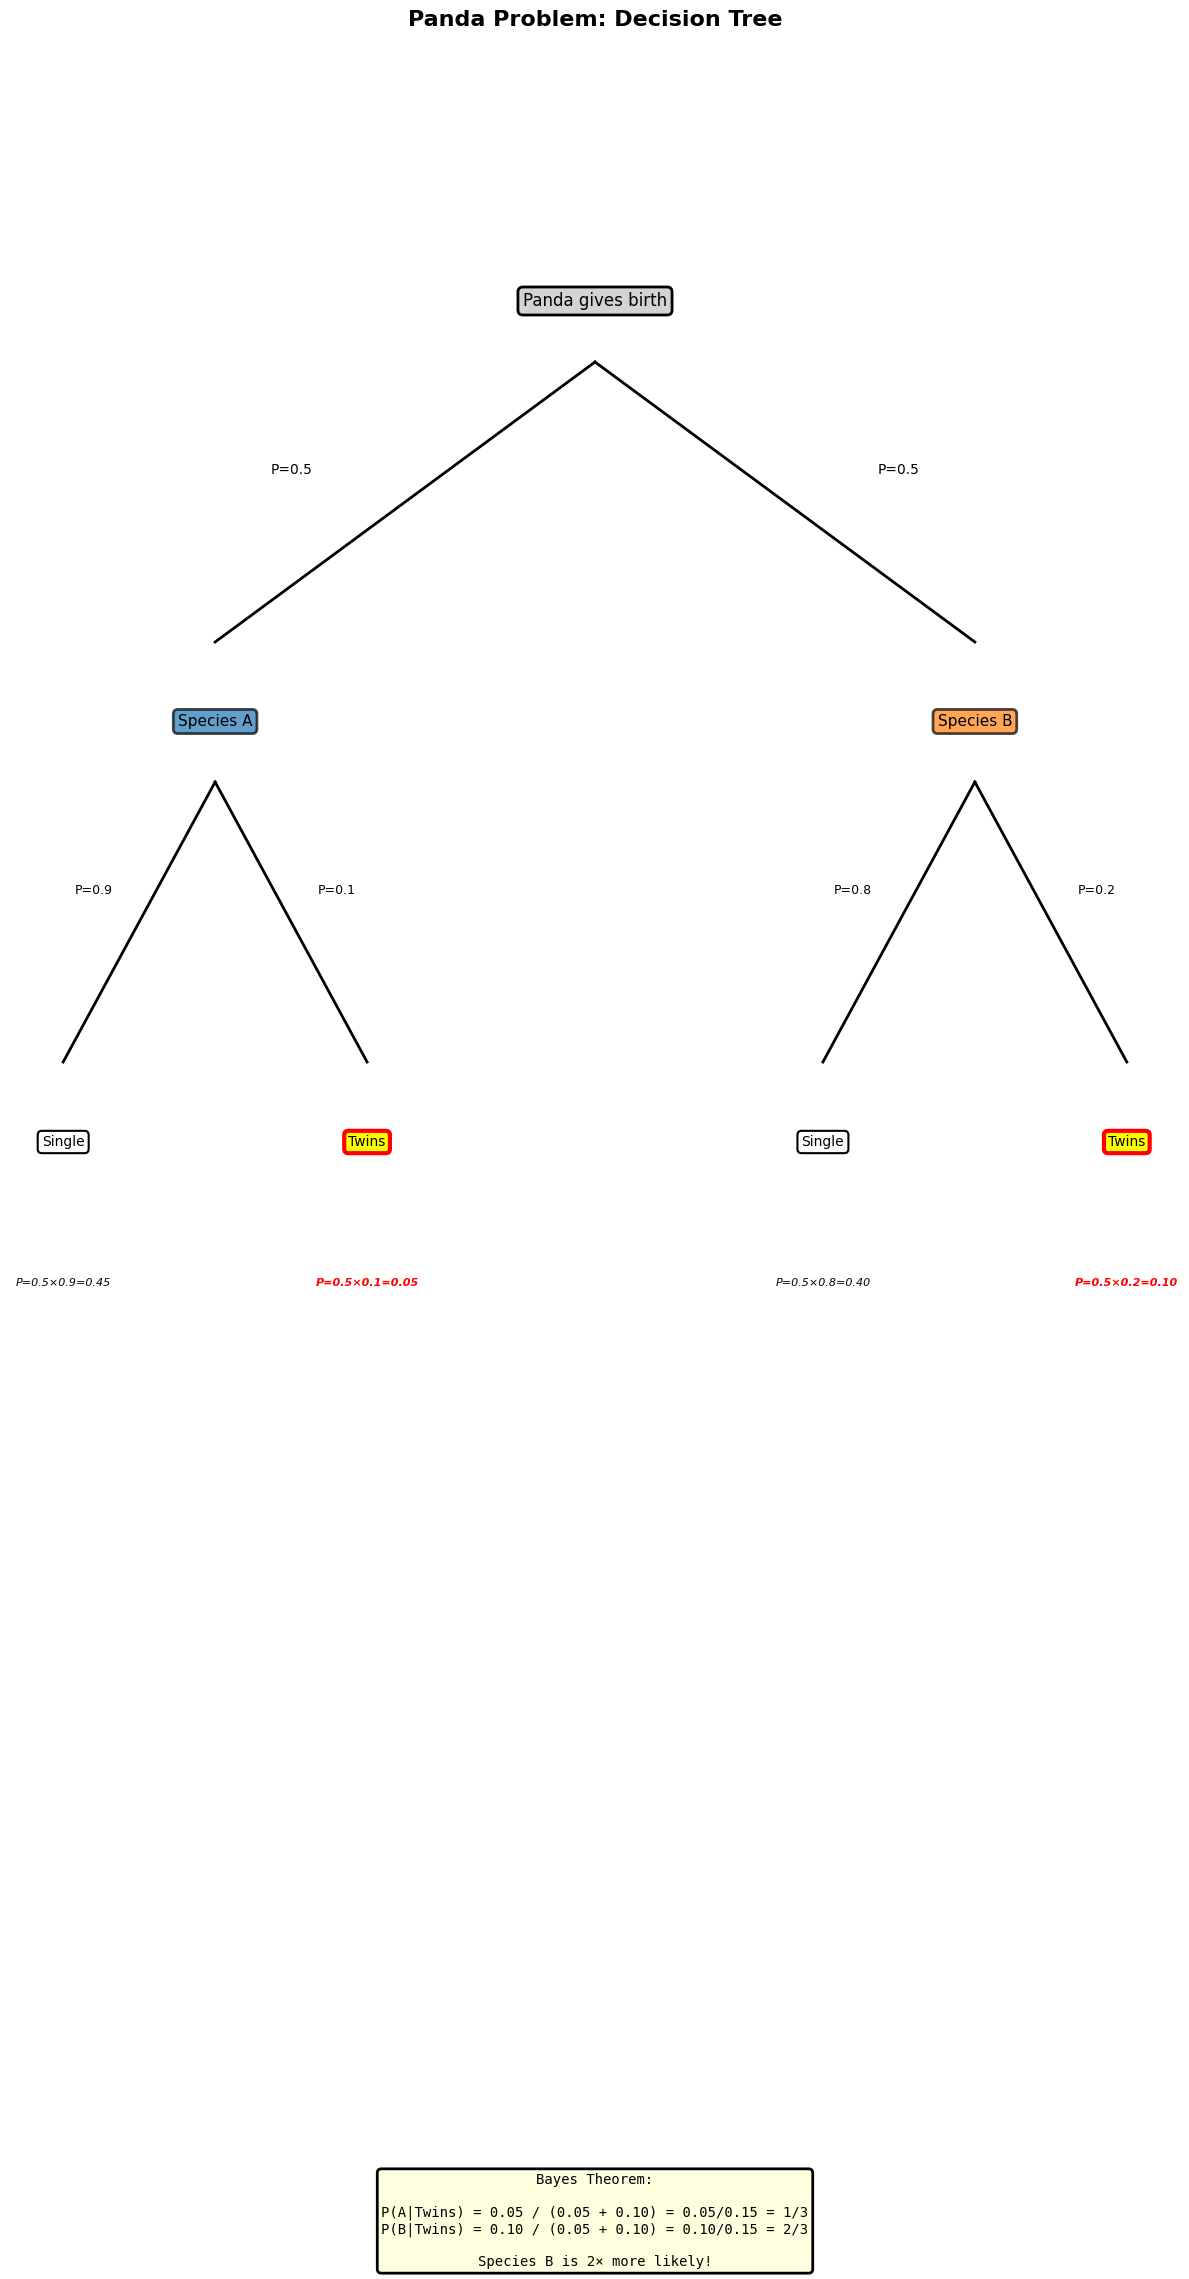

In [13]:
# Create a decision tree visualization
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('off')

# Title
ax.text(0.5, 0.95, 'Panda Problem: Decision Tree', 
        ha='center', fontsize=16, fontweight='bold')

# Start
ax.text(0.5, 0.85, 'Panda gives birth', 
        ha='center', fontsize=12, 
        bbox=dict(boxstyle='round', facecolor='lightgray', edgecolor='black', linewidth=2))

# Branch to species
ax.plot([0.5, 0.25], [0.83, 0.73], 'k-', linewidth=2)
ax.plot([0.5, 0.75], [0.83, 0.73], 'k-', linewidth=2)
ax.text(0.3, 0.79, 'P=0.5', ha='center', fontsize=10)
ax.text(0.7, 0.79, 'P=0.5', ha='center', fontsize=10)

# Species nodes
ax.text(0.25, 0.70, 'Species A', 
        ha='center', fontsize=11, 
        bbox=dict(boxstyle='round', facecolor='#1f77b4', 
                  edgecolor='black', linewidth=2, alpha=0.7))
ax.text(0.75, 0.70, 'Species B', 
        ha='center', fontsize=11, 
        bbox=dict(boxstyle='round', facecolor='#ff7f0e', 
                  edgecolor='black', linewidth=2, alpha=0.7))

# Branch to outcomes for Species A
ax.plot([0.25, 0.15], [0.68, 0.58], 'k-', linewidth=2)
ax.plot([0.25, 0.35], [0.68, 0.58], 'k-', linewidth=2)
ax.text(0.17, 0.64, 'P=0.9', ha='center', fontsize=9)
ax.text(0.33, 0.64, 'P=0.1', ha='center', fontsize=9)

# Branch to outcomes for Species B
ax.plot([0.75, 0.65], [0.68, 0.58], 'k-', linewidth=2)
ax.plot([0.75, 0.85], [0.68, 0.58], 'k-', linewidth=2)
ax.text(0.67, 0.64, 'P=0.8', ha='center', fontsize=9)
ax.text(0.83, 0.64, 'P=0.2', ha='center', fontsize=9)

# Outcome nodes
ax.text(0.15, 0.55, 'Single', 
        ha='center', fontsize=10, 
        bbox=dict(boxstyle='round', facecolor='white', 
                  edgecolor='black', linewidth=1.5))
ax.text(0.35, 0.55, 'Twins', 
        ha='center', fontsize=10, 
        bbox=dict(boxstyle='round', facecolor='yellow', 
                  edgecolor='red', linewidth=3))
ax.text(0.65, 0.55, 'Single', 
        ha='center', fontsize=10, 
        bbox=dict(boxstyle='round', facecolor='white', 
                  edgecolor='black', linewidth=1.5))
ax.text(0.85, 0.55, 'Twins', 
        ha='center', fontsize=10, 
        bbox=dict(boxstyle='round', facecolor='yellow', 
                  edgecolor='red', linewidth=3))

# Joint probabilities
ax.text(0.15, 0.50, 'P=0.5×0.9=0.45', ha='center', fontsize=8, style='italic')
ax.text(0.35, 0.50, 'P=0.5×0.1=0.05', ha='center', fontsize=8, 
        style='italic', fontweight='bold', color='red')
ax.text(0.65, 0.50, 'P=0.5×0.8=0.40', ha='center', fontsize=8, style='italic')
ax.text(0.85, 0.50, 'P=0.5×0.2=0.10', ha='center', fontsize=8, 
        style='italic', fontweight='bold', color='red')

# Observation arrow
ax.annotate('WE OBSERVED\nTWINS!', 
            xy=(0.35, 0.48), xytext=(0.5, 0.35),
            ha='center', fontsize=11, fontweight='bold', color='red',
            arrowprops=dict(arrowstyle='->', color='red', lw=2))
ax.annotate('', 
            xy=(0.85, 0.48), xytext=(0.5, 0.35),
            arrowprops=dict(arrowstyle='->', color='red', lw=2))

# Calculation box
calc_text = """Bayes Theorem:

P(A|Twins) = 0.05 / (0.05 + 0.10) = 0.05/0.15 = 1/3
P(B|Twins) = 0.10 / (0.05 + 0.10) = 0.10/0.15 = 2/3

Species B is 2× more likely!"""

ax.text(0.5, 0.15, calc_text, 
        ha='center', fontsize=10, family='monospace',
        bbox=dict(boxstyle='round', facecolor='lightyellow', 
                  edgecolor='black', linewidth=2))

plt.tight_layout()
plt.show()

### Extension: What if we observe a SECOND birth?

EXTENSION: Sequential Updating with Second Birth

After 1st birth (twins):
  P(A | 1st twins) = 0.333
  P(B | 1st twins) = 0.667
  ← These become our new priors!

----------------------------------------------------------------------
Scenario: 2nd birth is ALSO twins
----------------------------------------------------------------------

P(A | 2 twins) = 0.2000 = 20.0%
P(B | 2 twins) = 0.8000 = 80.0%

Now Species B is 4.0× more likely!

----------------------------------------------------------------------
Scenario: 2nd birth is SINGLE
----------------------------------------------------------------------

P(A | twins, then single) = 0.3600 = 36.0%
P(B | twins, then single) = 0.6400 = 64.0%

Species B is 1.8× more likely
(Less certain than with 2 twins, but still favors B)


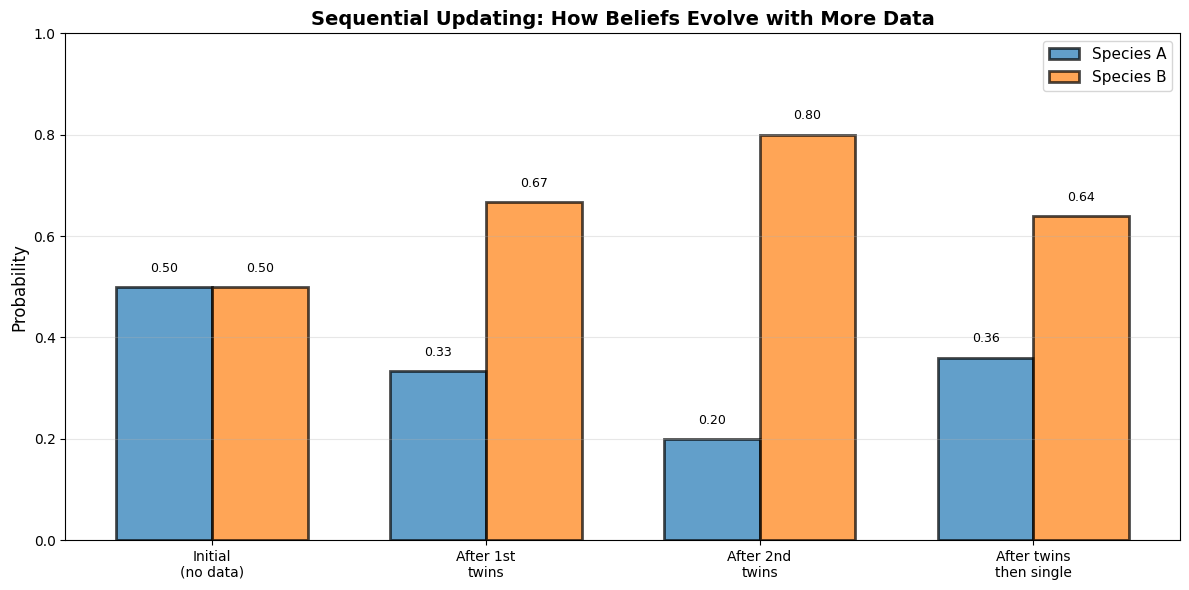


Key Insights:
1. Each observation updates our beliefs (sequential learning)
2. More twins = more confident it's Species B
3. A single birth pulls us slightly back toward Species A
4. We never reach 100% certainty (always some uncertainty)


In [14]:
# Sequential updating: What happens with a second birth?

print("="*70)
print("EXTENSION: Sequential Updating with Second Birth")
print("="*70)

# After first twins, our posterior becomes the new prior
prior_a_after_twins = p_a_given_twins
prior_b_after_twins = p_b_given_twins

print("\nAfter 1st birth (twins):")
print(f"  P(A | 1st twins) = {prior_a_after_twins:.3f}")
print(f"  P(B | 1st twins) = {prior_b_after_twins:.3f}")
print("  ← These become our new priors!")

# Scenario: Second birth is ALSO twins
print("\n" + "-"*70)
print("Scenario: 2nd birth is ALSO twins")
print("-"*70)

# Normalizing constant
p_2nd_twins = (p_twins_given_a * prior_a_after_twins + 
               p_twins_given_b * prior_b_after_twins)

# Updated posterior
p_a_after_2_twins = (p_twins_given_a * prior_a_after_twins) / p_2nd_twins
p_b_after_2_twins = (p_twins_given_b * prior_b_after_twins) / p_2nd_twins

print(f"\nP(A | 2 twins) = {p_a_after_2_twins:.4f} = {p_a_after_2_twins:.1%}")
print(f"P(B | 2 twins) = {p_b_after_2_twins:.4f} = {p_b_after_2_twins:.1%}")
print(f"\nNow Species B is {p_b_after_2_twins/p_a_after_2_twins:.1f}× more likely!")

# Scenario: Second birth is single
print("\n" + "-"*70)
print("Scenario: 2nd birth is SINGLE")
print("-"*70)

p_single_given_a = 1 - p_twins_given_a
p_single_given_b = 1 - p_twins_given_b

p_2nd_single = (p_single_given_a * prior_a_after_twins + 
                p_single_given_b * prior_b_after_twins)

p_a_after_twins_single = (p_single_given_a * prior_a_after_twins) / p_2nd_single
p_b_after_twins_single = (p_single_given_b * prior_b_after_twins) / p_2nd_single

print(f"\nP(A | twins, then single) = {p_a_after_twins_single:.4f} = {p_a_after_twins_single:.1%}")
print(f"P(B | twins, then single) = {p_b_after_twins_single:.4f} = {p_b_after_twins_single:.1%}")
print(f"\nSpecies B is {p_b_after_twins_single/p_a_after_twins_single:.1f}× more likely")
print("(Less certain than with 2 twins, but still favors B)")

# Visualize evolution
fig, ax = plt.subplots(figsize=(12, 6))

scenarios = ['Initial\n(no data)', 'After 1st\ntwins', 'After 2nd\ntwins', 'After twins\nthen single']
prob_a = [0.5, p_a_given_twins, p_a_after_2_twins, p_a_after_twins_single]
prob_b = [0.5, p_b_given_twins, p_b_after_2_twins, p_b_after_twins_single]

x = np.arange(len(scenarios))
width = 0.35

bars1 = ax.bar(x - width/2, prob_a, width, label='Species A', 
               color='#1f77b4', alpha=0.7, edgecolor='black', linewidth=2)
bars2 = ax.bar(x + width/2, prob_b, width, label='Species B', 
               color='#ff7f0e', alpha=0.7, edgecolor='black', linewidth=2)

ax.set_ylabel('Probability', fontsize=12)
ax.set_title('Sequential Updating: How Beliefs Evolve with More Data', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(scenarios, fontsize=10)
ax.legend(fontsize=11)
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (va, vb) in enumerate(zip(prob_a, prob_b)):
    ax.text(i - width/2, va + 0.03, f'{va:.2f}', ha='center', fontsize=9)
    ax.text(i + width/2, vb + 0.03, f'{vb:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("1. Each observation updates our beliefs (sequential learning)")
print("2. More twins = more confident it's Species B")
print("3. A single birth pulls us slightly back toward Species A")
print("4. We never reach 100% certainty (always some uncertainty)")

---

## 10. Summary and Key Takeaways

### The Bayesian Workflow (Recap)

1. **Prior P(θ)**: Start with initial beliefs about parameters
2. **Likelihood P(D|θ)**: Connect parameters to data through generative model
3. **Posterior P(θ|D)**: Update beliefs by multiplying prior × likelihood and normalizing
4. **Prediction P(D_new|D)**: Make predictions by integrating over posterior uncertainty

### Key Equations

**Bayes Theorem:**
$$P(\theta|D) = \frac{P(D|\theta) \times P(\theta)}{P(D)}$$

**Normalizing Constant:**
$$P(D) = \int P(D|\theta) \times P(\theta) \, d\theta$$

**Proportionality (computational shortcut):**
$$P(\theta|D) \propto P(D|\theta) \times P(\theta)$$

**Posterior Predictive:**
$$P(D_{new}|D) = \int P(D_{new}|\theta) \times P(\theta|D) \, d\theta$$

### Critical Distinctions

1. **Likelihood vs Probability**:
   - Same numerical value, different interpretations
   - In Bayes theorem, P(D|θ) is a likelihood (function of θ)

2. **Posterior vs Prediction**:
   - Posterior: Distribution over parameters θ
   - Prediction: Distribution over new data D_new
   - Prediction is wider (accounts for both parameter and sampling uncertainty)

3. **Prior vs Posterior**:
   - Prior: Before seeing data
   - Posterior: After seeing data
   - Today's posterior = Tomorrow's prior (sequential updating)

### Computational Methods

**Grid Approximation:**
- Simple and intuitive
- Works for 1-2 parameters
- Curse of dimensionality for more parameters

**For Complex Models:**
- Quadratic approximation (quap) - Chapter 4
- MCMC sampling - Chapter 9+
- Variational inference - Advanced topics

### Philosophical Insights

1. **Sequential Learning**: Bayesian inference is about updating beliefs as data accumulates
2. **Uncertainty Quantification**: We get full distributions, not just point estimates
3. **Small World vs Large World**: Model is perfect in small world, approximate in large world
4. **Priors are Necessary**: Every analysis has assumptions; Bayesian inference makes them explicit

### What's Next?

- **Chapter 3**: Sampling from posterior (MCMC preview)
- **Chapter 4**: Linear regression with quap (what we did in exercises!)
- **Chapter 5+**: More complex models, multiple predictors, interactions

---

**The Panda Problem** ties everything together:
- Started with uniform prior (no preference)
- Used likelihood to connect species to twin observations
- Applied Bayes theorem to update beliefs
- Demonstrated sequential updating with multiple births
- Showed how data overcomes prior beliefs

This is the essence of Bayesian inference!